In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
import time
import random
from scipy.ndimage.filters import gaussian_filter1d

In [2]:
# Preparing the Problem

Ac = np.array( [ [ -0.15 , 1.90 , 1.55 ] , [ 0.5 , -0.3 , 0.1 ] , [ 0.2  , 0.5 , -2.55 ]] )
Bc = np.array( [ [ 0.55 , -0.64 , 0.16 ] , [ 1.69 , 0.38 , 0  ] , [ 0.59 , -1.5 , 1.31 ]] )
Cc = np.array( [ [ 1 , 1 , 0 ] , [ 0 , 0 , 1 ] , [ 1 , 1 , 1 ] ] )
L  = np.array( [ [ 2 , -1 , -1 , 0 ] , [ -1 , 1 , 0 , 0 ] , [ -1 , 0 , 2 , -1 ] , [ 0 , 0 , -1 , 1 ] ] )
F1 = np.array( [ [ 0.7079 , -0.7108 , 0.0000] , [-2.3683 , 2.0355 , -0.0001 ] , [-3.9801 , 5.6377 , -0.0002] ] )
F2 = np.array( [ [ 0.0112 , 0.0362 , 0.0067] , [0.0272 , 0.1052 , 0.0247 ] , [0.0905 , 1.9489 , 0.2216] ] )

# A, B, C, F matrices for continuous Systems
Ac =   np.kron( np.identity(4) , Ac )
Bc =   np.kron( np.identity(4) , Bc )
Cc =   np.kron( np.identity(4) , Cc )
Fc =  -np.kron( np.identity(4) , F1 ) - np.kron( L , F2 )



In [3]:
def SpectralRadiusNormalized(A):
    return A / (np.amax(np.absolute(np.linalg.eigvals(A))) + 0.0001)

def Discretize(SamplingPeriod, Ac, Bc, Cc, Fc):
    big = np.zeros((24,24))
    big[0:12, 0:12] = Ac
    big[0:12,12:24] = Bc
    bigd = scipy.linalg.expm(big * SamplingPeriod)

    A = bigd[ 0:12,  0:12 ]
    B = bigd[ 0:12, 12:24 ]
    
    A = SpectralRadiusNormalized(A)

    return A, B, Cc, Fc

In [4]:
A, B, C, F = Discretize(0.01, Ac, Bc, Cc, Fc)
alpha = min((np.linalg.eigvals(A))) - 0.00001
x_plot = []
initialstate = np.array([[-0.527029],
                         [ 0.152074],
                         [ 1.259488],
                         [ 1.018136],
                         [ 1.0347  ],
                         [-0.066806],
                         [-0.221626],
                         [ 0.303806],
                         [-0.0323  ],
                         [ 0.45862 ],
                         [-1.113736],
                         [ 0.702659]])

x = initialstate

for i in range(0, 800):
    y = np.matmul(C , x)
    x = np.matmul(A , x) + np.matmul(B , np.matmul(F , y))
    x_plot.append(np.sum(x))

    
# plt.plot(x_plot)
# plt.show()

In [5]:
def GradientMatrix(x):
    
    CX = np.zeros((T, P, 1))
    M  = np.zeros((T, P, 1))
    SignMatrix  = np.zeros((T, P, 1))    
    Anew = np.zeros((N,N))
    Anew[:,:] = A[:,:]
    X = np.zeros((T , N , 1))
    X[0, :, :] = x

    for t in range(0, T - 1):
        X[t + 1 , : , :] = np.matmul(A, X[t , : , :]) + np.matmul(B , np.matmul(F , np.matmul(C, X[t , : , :])))

    for t in range(0, T):
        CX[t, :, :] = np.matmul(C, X[t, :, :])

    M = Y - CX
    SignMatrix[:, :, :] = M[:, :, :]
    SignMatrix[SignMatrix <=  0] =  1
    SignMatrix[SignMatrix >   0] = -1

    Sum = (np.sum(M ** 2, axis = 0)) ** -0.5
    
    derivative = np.zeros((N, 1))
    for n in range(0, N):
        Calc = np.zeros((P, 1))
        Calc = M[0, :, :] * SignMatrix[0, :, :] * C[:,n:n+1]
        for t in range(1, T):
            Calc = Calc + M[t, :, :] * SignMatrix[t, :, :] * (np.matmul(C , Anew))[:,n:n+1]
            Anew = np.matmul(Anew, A)
        derivative[n, 0] = np.sum(Sum * Calc)
    return derivative

In [ ]:
# Running the full project
# Estimated time = 15 hours (choosing 10000 iterations per simulation)

T = 500 # Timesteps
P = 12  # Total Sensors/Outputs
N = 12  # Total States

e = np.zeros((12, 10, 12)) # no. of sensors attacked, which simulation, which sensor
for q in range(0, 12):
    for simulation in range(0, 10):
        
        #  Generating Attack
        sensors = random.sample(range(12), 12 - q)
        E = np.random.normal(0, 3, (T, P, 1))  # Error Vector
        for i in sensors:
            E[:, i ,:] = 0
        
        # Generating Attacked Outputs
        Y  = np.zeros((T , P , 1))
        Xa = np.zeros((T , N , 1))
        Xa[0, :, :] = initialstate

        for t in range(0 , T - 1):
            Y[ t     , : , :]  = np.matmul(C, Xa[t , : , :]) + E[t , : , :]
            Xa[t + 1 , : , :]  = np.matmul(A, Xa[t , : , :]) + np.matmul(B , np.matmul(F , Y[t , : , :]))
        Y[T - 1 , : , :] = np.matmul(C, Xa[T - 1 , : , :])
        
        # Estimating x using gradient descent
        X = np.zeros((N,1))  # initial guess
        x_plot = []
        iterations = 0

        while iterations < 10000:
            delLoss = GradientMatrix(X)
            X = X - 0.001 * delLoss
            x_plot.append(np.sum(np.abs(X-initialstate)))
            iterations = iterations + 1
#             print(q,simulation,iterations)
            
#         plt.plot(x_plot)
#         plt.title("Error vs iterations. Sensors compromised: " + str(q) + ", Simulation no: " + str(simulation))
#         plt.savefig("Sensors"+str(q)+"Graph"+str(simulation)+".png")
#         plt.clf()

        e[q, simulation, :] = np.abs(np.squeeze(X - initialstate))
        


In [ ]:
np.save("ErrorNumpy", e)
plt.plot(  (np.sum((np.sum(e , axis = 2) / 12), axis = 1))/10  )
plt.title("Error vs Number of Sensors compromised")
plt.savefig("FinalGraph.png")

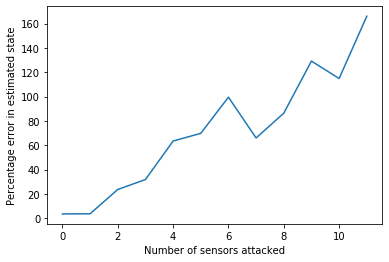

In [12]:
initialstate = np.squeeze(np.array([ [-0.527029],
                                     [ 0.152074],
                                     [ 1.259488],
                                     [ 1.018136],
                                     [ 1.0347  ],
                                     [-0.066806],
                                     [-0.221626],
                                     [ 0.303806],
                                     [-0.0323  ],
                                     [ 0.45862 ],
                                     [-1.113736],
                                     [ 0.702659]]))
e1 = np.load("ErrorNumpy1.npy")
e_n = np.zeros((12,10,12))

for q in range(0, 12):
    for simu in range(0, 10):
        e_n[q , simu, :] = np.abs( np.divide(e1[q, simu, :] , initialstate) ) * 100
        
e_av = np.sum(e_n, axis = 2) / 12

e_min = np.amin(e_av, axis = 1) 

plt.plot(e_min)
smoothed = gaussian_filter1d( e_min , sigma=1)
# plt.plot(smoothed, color = 'r')
plt.xlabel("Number of sensors attacked")
plt.ylabel("Percentage error in estimated state")
plt.show()